In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Gymnasium is the library that provides the CartPole environment
import gymnasium as gym

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

from itertools import count
import random
from random import sample
from random import random

In [3]:
# Neural network for the FF algorithm
# https://github.com/mohammadpz/pytorch_forward_forward/blob/main/main.py
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]

    def predict(self, x):
        goodness_per_label = []
        for label in range(2):  # 10 for mnist
            h = torch.tensor([x.tolist() + [label]])
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

    def is_good(self, x):
        goodness = []
        h = x.clone().detach()   # .tolist()
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        return -sum(goodness)

In [4]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.0003)
        self.threshold = 2.0
        self.num_epochs = 1

    def forward(self, x):
        # print(x.shape)
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # normalization
        # torch.mm -> matrix multiplication
        out = self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

        return out

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            out_pos = self.forward(x_pos)
            out_neg = self.forward(x_neg)
            g_pos = out_pos.pow(2).mean(1)
            g_neg = out_neg.pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=2)
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [5]:
# Function to play episodes and extract positive and negative data
def get_posneg_data(epsilon=0.5, N=5, look_next = False, thresh=0.5):
    negative_data = []
    positive_data = []
    game_lens = []
    for i_episode in range(200):
        state, info = env.reset()
        game = []
        for t in count():
            s = random()
            if s > epsilon:
                action = env.action_space.sample()
            else:
                action = net.predict(torch.tensor(state)).item()
            observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if terminated:
                next_state = None
                game.append(state.tolist() + [action])
            else:
                next_state = observation
                game.append(state.tolist() + [action])
                if look_next and (net.is_good(torch.tensor([next_state.tolist() + [0]])) < thresh and
                                  net.is_good(torch.tensor([next_state.tolist() + [1]])) < thresh):
                    negative_data.append(state.tolist() + [action])
            state = next_state
            if done:
                break
        game_lens.append(len(game))
        if len(game) > N and not truncated:
            negative_data += game[-N:]
            positive_data += game[:-N]
        else:
            negative_data += game
    mean_len=sum(game_lens)/200
    # print(mean_len)
    pos_len = len(positive_data)
    neg_len = len(negative_data)
    # print(pos_len)
    # print(neg_len)
    if pos_len > neg_len:
        positive_data = sample(positive_data, neg_len)
    else:
        negative_data = sample(negative_data, pos_len)
    return torch.tensor(positive_data), torch.tensor(negative_data), mean_len


In [6]:
net = Net([5, 100, 100])
env = gym.make("CartPole-v1")
n_iters = 3 # 200
mean_lens = []
m=10

# Training loop
for i in range(n_iters):
    eps = 0.8*(1-i/n_iters)
    pos_data, neg_data, m = get_posneg_data(epsilon=eps, N=3) # , look_next = l_n, thresh=0.2
    mean_lens.append(m)
    net.train(pos_data, neg_data)

training layer 0 ...


100%|██████████| 1/1 [00:00<00:00, 72.53it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 136.13it/s]


training layer 0 ...


100%|██████████| 1/1 [00:00<00:00, 64.33it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 66.29it/s]


training layer 0 ...


100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


training layer 1 ...


100%|██████████| 1/1 [00:00<00:00, 64.19it/s]


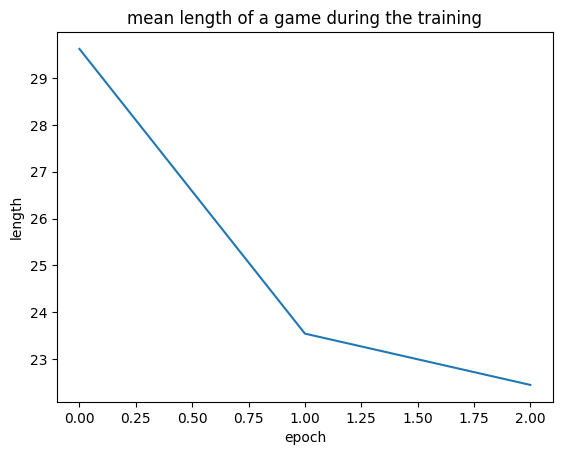

In [7]:
import matplotlib.pyplot as plt

plt.plot(mean_lens)
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

In [8]:
print(mean_lens)

[29.62, 23.545, 22.45]


## Training plot for different proportions of negative data

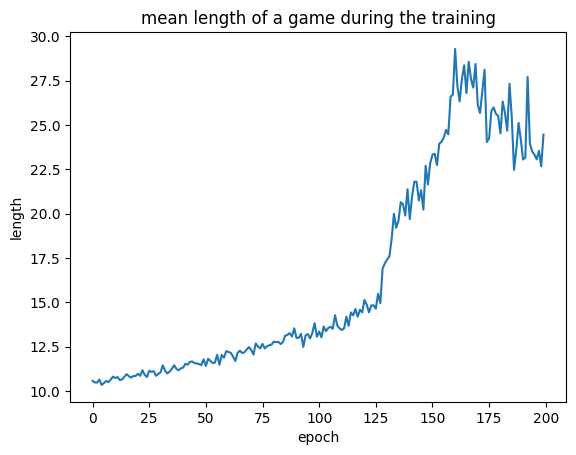

In [9]:
import matplotlib.pyplot as plt

# 30 % of game is negative
plt.plot([10.565, 10.475, 10.47, 10.635, 10.335, 10.44, 10.56, 10.49, 10.635, 10.805, 10.725, 10.78, 10.61, 10.645, 10.785, 10.945, 10.83, 10.745, 10.84, 10.84, 10.96, 10.85, 11.165, 10.905, 10.78, 11.135, 11.065, 11.11, 10.85, 10.96, 11.05, 11.435, 11.13, 10.98, 11.09, 11.24, 11.445, 11.24, 11.165, 11.27, 11.32, 11.535, 11.475, 11.64, 11.655, 11.565, 11.545, 11.515, 11.45, 11.775, 11.405, 11.81, 11.69, 11.57, 11.595, 12.035, 11.47, 12.025, 11.875, 12.24, 12.195, 12.14, 11.935, 11.685, 12.14, 12.27, 12.14, 12.17, 12.33, 12.47, 12.315, 12.045, 12.675, 12.495, 12.4, 12.645, 12.39, 12.52, 12.57, 12.61, 12.775, 12.75, 12.76, 12.645, 12.75, 13.11, 13.155, 13.26, 13.065, 13.53, 12.985, 12.995, 13.215, 12.475, 13.125, 13.205, 12.955, 13.275, 13.825, 13.055, 13.345, 13.02, 13.63, 13.37, 13.545, 13.615, 13.5, 14.27, 13.695, 13.525, 13.435, 13.525, 14.185, 13.67, 14.425, 14.26, 14.62, 14.18, 14.575, 14.43, 15.13, 14.855, 14.43, 14.82, 14.83, 14.64, 15.48, 14.95, 16.9, 17.195, 17.415, 17.59, 18.58, 19.99, 19.2, 19.59, 20.645, 20.525, 19.89, 21.375, 19.69, 20.965, 21.8, 21.795, 20.74, 21.32, 20.225, 22.7, 21.645, 22.845, 23.32, 23.375, 22.74, 23.94, 24.055, 24.295, 24.725, 24.47, 26.6, 26.7, 29.29, 27.195, 26.33, 27.6, 28.37, 26.8, 28.565, 27.61, 27.11, 28.44, 26.14, 25.675, 26.9, 28.115, 24.04, 24.235, 25.79, 25.985, 25.63, 25.505, 24.52, 26.32, 25.67, 24.68, 27.325, 25.465, 22.47, 23.61, 25.12, 24.18, 23.05, 23.16, 27.71, 23.945, 23.51, 23.33, 23.06, 23.545, 22.67, 24.455])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

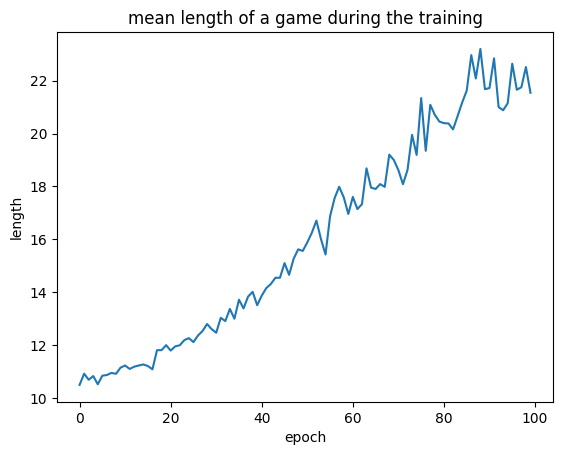

In [10]:
# N=1
plt.plot([10.49, 10.915, 10.685, 10.825, 10.515, 10.84, 10.865, 10.945, 10.91, 11.145, 11.225, 11.095, 11.18, 11.225, 11.265, 11.205, 11.08, 11.805, 11.805, 11.995, 11.79, 11.95, 11.99, 12.185, 12.26, 12.11, 12.36, 12.53, 12.795, 12.6, 12.465, 13.03, 12.905, 13.365, 12.995, 13.715, 13.385, 13.835, 14.01, 13.505, 13.87, 14.155, 14.31, 14.545, 14.545, 15.1, 14.655, 15.265, 15.62, 15.56, 15.885, 16.25, 16.71, 16.01, 15.425, 16.875, 17.56, 17.99, 17.59, 16.96, 17.605, 17.145, 17.33, 18.685, 17.955, 17.905, 18.09, 17.985, 19.205, 19.0, 18.62, 18.085, 18.625, 19.955, 19.195, 21.345, 19.35, 21.09, 20.71, 20.455, 20.395, 20.385, 20.16, 20.665, 21.175, 21.625, 22.97, 22.085, 23.205, 21.68, 21.725, 22.85, 21.005, 20.885, 21.15, 22.645, 21.66, 21.755, 22.52, 21.545])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

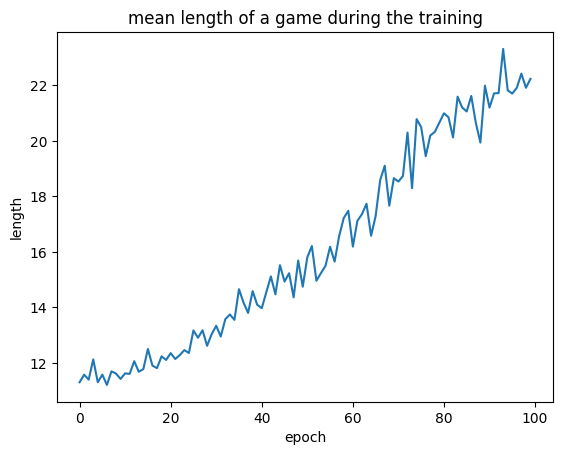

In [11]:
# N=2
plt.plot([11.3, 11.575, 11.395, 12.125, 11.3, 11.575, 11.205, 11.695, 11.615, 11.42, 11.62, 11.605, 12.06, 11.68, 11.775, 12.5, 11.9, 11.81, 12.235, 12.105, 12.35, 12.14, 12.28, 12.46, 12.355, 13.17, 12.905, 13.175, 12.615, 13.035, 13.335, 12.95, 13.575, 13.745, 13.55, 14.655, 14.17, 13.8, 14.585, 14.095, 13.97, 14.545, 15.115, 14.47, 15.52, 14.93, 15.23, 14.36, 15.69, 14.745, 15.805, 16.21, 14.96, 15.235, 15.5, 16.185, 15.65, 16.575, 17.22, 17.48, 16.19, 17.12, 17.36, 17.735, 16.58, 17.29, 18.585, 19.105, 17.665, 18.655, 18.535, 18.735, 20.3, 18.295, 20.785, 20.495, 19.45, 20.195, 20.325, 20.66, 20.995, 20.85, 20.125, 21.595, 21.205, 21.06, 21.62, 20.65, 19.94, 21.99, 21.2, 21.71, 21.725, 23.315, 21.82, 21.705, 21.915, 22.425, 21.915, 22.235])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

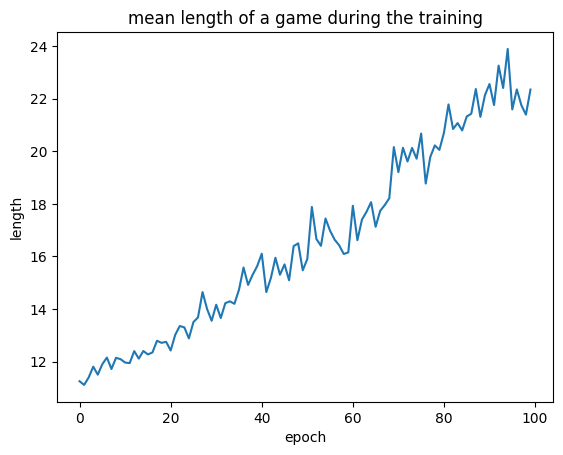

In [12]:
# N=3
plt.plot([11.255, 11.115, 11.4, 11.81, 11.505, 11.905, 12.155, 11.72, 12.145, 12.095, 11.965, 11.945, 12.4, 12.115, 12.405, 12.275, 12.35, 12.795, 12.715, 12.755, 12.425, 13.02, 13.355, 13.305, 12.885, 13.505, 13.685, 14.645, 14.0, 13.555, 14.165, 13.66, 14.225, 14.295, 14.2, 14.735, 15.58, 14.92, 15.305, 15.635, 16.105, 14.645, 15.18, 15.95, 15.305, 15.7, 15.095, 16.395, 16.5, 15.475, 15.905, 17.885, 16.665, 16.405, 17.445, 16.98, 16.64, 16.425, 16.095, 16.155, 17.93, 16.62, 17.405, 17.7, 18.065, 17.13, 17.735, 17.955, 18.215, 20.16, 19.21, 20.135, 19.615, 20.13, 19.72, 20.675, 18.775, 19.785, 20.225, 20.055, 20.705, 21.785, 20.85, 21.075, 20.795, 21.325, 21.43, 22.37, 21.31, 22.135, 22.56, 21.76, 23.26, 22.41, 23.895, 21.595, 22.355, 21.755, 21.395, 22.35])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

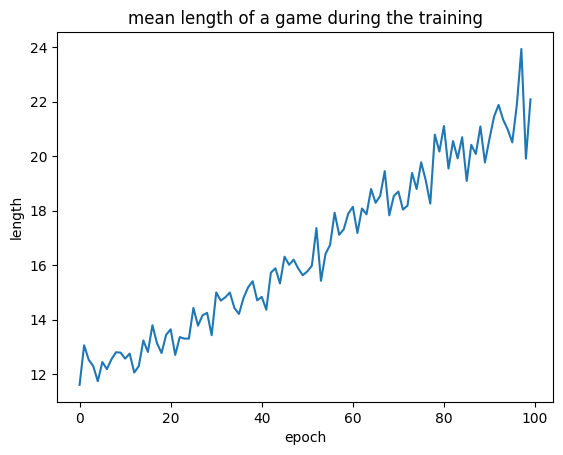

In [13]:
# N=4
plt.plot([11.6, 13.055, 12.525, 12.29, 11.735, 12.44, 12.18, 12.54, 12.8, 12.785, 12.565, 12.75, 12.055, 12.29, 13.23, 12.81, 13.79, 13.13, 12.77, 13.435, 13.64, 12.7, 13.355, 13.3, 13.3, 14.425, 13.775, 14.155, 14.245, 13.425, 14.995, 14.695, 14.815, 14.99, 14.42, 14.205, 14.795, 15.18, 15.405, 14.705, 14.83, 14.36, 15.72, 15.88, 15.325, 16.305, 16.01, 16.195, 15.875, 15.625, 15.765, 15.975, 17.355, 15.42, 16.41, 16.735, 17.92, 17.11, 17.31, 17.89, 18.135, 17.175, 18.075, 17.86, 18.79, 18.285, 18.535, 19.445, 17.825, 18.535, 18.695, 18.035, 18.18, 19.38, 18.79, 19.77, 19.11, 18.255, 20.785, 20.165, 21.1, 19.54, 20.55, 19.915, 20.69, 19.085, 20.41, 20.075, 21.085, 19.765, 20.635, 21.445, 21.875, 21.335, 20.975, 20.5, 21.87, 23.93, 19.905, 22.08])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

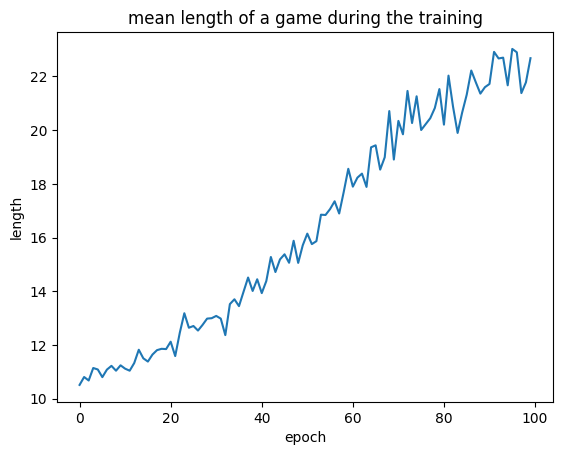

In [14]:
# N=5
plt.plot([10.51, 10.805, 10.675, 11.14, 11.085, 10.8, 11.08, 11.22, 11.04, 11.24, 11.115, 11.04, 11.325, 11.82, 11.5, 11.38, 11.64, 11.805, 11.855, 11.845, 12.12, 11.585, 12.45, 13.18, 12.64, 12.705, 12.535, 12.745, 12.98, 12.995, 13.08, 12.98, 12.365, 13.52, 13.7, 13.445, 13.98, 14.51, 14.01, 14.445, 13.93, 14.38, 15.275, 14.715, 15.185, 15.375, 15.06, 15.88, 15.055, 15.71, 16.145, 15.755, 15.865, 16.85, 16.84, 17.06, 17.35, 16.895, 17.7, 18.56, 17.895, 18.23, 18.38, 17.885, 19.36, 19.435, 18.53, 18.99, 20.71, 18.905, 20.345, 19.845, 21.46, 20.265, 21.26, 20.005, 20.225, 20.445, 20.825, 21.53, 20.205, 22.03, 20.87, 19.895, 20.655, 21.32, 22.22, 21.78, 21.36, 21.6, 21.72, 22.915, 22.67, 22.7, 21.67, 23.025, 22.9, 21.38, 21.78, 22.68])
plt.title("mean length of a game during the training")
plt.xlabel("epoch")
plt.ylabel("length")
plt.show()

## Saving a video

In [15]:
env = gym.wrappers.RecordVideo(gym.make("CartPole-v1", render_mode='rgb_array'), "videos")

state, info = env.reset()
env.start_video_recorder()

rewards = []
for t in count():
    action = net.predict(state).item()
    # print(action)
    observation, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    env.render()
    done = terminated or truncated
    if terminated:
        next_state = None
    else:
        next_state = observation
    state = next_state
    # print(t)
    if done:
        break

print("Over")
env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Over
